In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for clustering:
from sklearn.cluster import KMeans 
#for scaling/PCA:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
RAND = np.random.RandomState(seed = 1)

In [3]:
# static_data = pd.read_csv('https://raw.githubusercontent.com/J-Driesen/PD_goes_viral/master/static_data_20200904.csv')
static_data = pd.read_csv('static_data_20201006.csv')

#### Ruralness and Socioeconomic Status Indices

(Re-)Create Ruralness- and Socioeconomic-Status-Index, adapted from BMEL Landatlas studies, modified to generate values for all 401 districts in structural data:

In [4]:
Ruralness_vars = ['RUR_surrounding_pop', 'RUR_distance_to_urban_centers',
                  'RUR_area_share_farms_forests', 'RUR_settlement_density',
                  'RUR_share_of_1_2_family_homes']

loading_signs_ought_Ruralness = [-1,1,1,-1,1]

Socioecon_vars = ['SES_highschool_dropouts', 'SES_residence_vacancies',
                  'SES_unemployment', 'SES_average_income', 'SES_male_life_expectancy',
                  'SES_female_life_expectancy', 'SES_average_salary',
                  'SES_communal_tax_revenue', 'SES_net_migration']

loading_signs_ought_Socioecon = [-1,-1,-1,1,1,1,1,1,1]


Ruralness consists of settlement density, area percentage of farming and forest areas, residence percentage of 1- and 2-family houses, surrounding population densities weighted by distance, and distance to the next five urban centers.

Socioeconomic Status consists of unemplyment rate, mean salaries, mean income, communal tax revenue, net population migration, residence vacancies, life expectancy for men and women, and percentage of high-school drop-outs.

In [5]:
scaler = StandardScaler()

#First, create Ruralness Index:
df_unscaled_Ruralness = static_data[Ruralness_vars]
df_scaled_Ruralness = pd.DataFrame(scaler.fit_transform(df_unscaled_Ruralness), columns = Ruralness_vars)

pca_ = PCA(1, random_state = RAND)
pca_.fit(df_scaled_Ruralness)
variance_explained_Ruralness = pca_.explained_variance_ratio_
print("Ruralness Index captures %4.1f %% of the variance in its %d constituents." % 
      ((variance_explained_Ruralness * 100), len(Ruralness_vars)))

#this next part checks whether loadings are all in the right direction
loading_signs_found_Ruralness = np.sign(pca_.components_)

if (loading_signs_found_Ruralness == loading_signs_ought_Ruralness).all():
    static_data['Ruralness_Index'] = pca_.transform(df_scaled_Ruralness)
elif (- loading_signs_found_Ruralness == loading_signs_ought_Ruralness).all():
    #if they are simply reversed, i.e. doing a urbanness index, they are re-reversed here:
    static_data['Ruralness_Index'] = - pca_.transform(df_scaled_Ruralness)
else:
    raise ValueError('Ruralness-loadings were not as expected! Reversing their signs did not help!')
    
static_data['rur_z'] = scaler.fit_transform(static_data['Ruralness_Index'].values.reshape(-1,1))


Ruralness Index captures 75.7 % of the variance in its 5 constituents.


In [6]:
#Next, the same for the Socioeconomic status:
df_unscaled_Socioecon = static_data[Socioecon_vars]
df_scaled_Socioecon = pd.DataFrame(scaler.fit_transform(df_unscaled_Socioecon), columns = Socioecon_vars)

pca_.fit(df_scaled_Socioecon)
variance_explained_Socioecon = pca_.explained_variance_ratio_
print("Socioeconomic Index captures %4.1f %% of the variance in its %d constituents." % 
      ((variance_explained_Socioecon * 100), len(Socioecon_vars)))

loading_signs_found_Socioecon = np.sign(pca_.components_) #same direction check as above

if (loading_signs_found_Socioecon == loading_signs_ought_Socioecon).all():
    static_data['Socioecon_Index'] = pca_.transform(df_scaled_Socioecon)
elif (- loading_signs_found_Socioecon == loading_signs_ought_Socioecon).all():
    static_data['Socioecon_Index'] = - pca_.transform(df_scaled_Socioecon)
else:
    raise ValueError('Socioecon-loadings were not as expected! Reversing their signs did not help!')

static_data['ses_z'] = scaler.fit_transform(static_data['Socioecon_Index'].values.reshape(-1,1))


Socioeconomic Index captures 54.2 % of the variance in its 9 constituents.


### Clustering

This clustering will no longer be used. Since it is ineffectual, and might at some points help with sanity checking, the code remains as is.

In [7]:
NUMBER_OF_CLUSTERS = 5  # identified through elbow method
CLUSTER_VARS = ['Ruralness_Index', 'Socioecon_Index']

In [8]:
kmeans = KMeans(NUMBER_OF_CLUSTERS, random_state = RAND)
static_data['cluster'] = kmeans.fit_predict(static_data[CLUSTER_VARS])

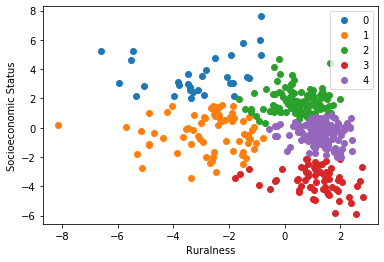

In [9]:
groups = static_data.groupby("cluster")
for name, group in groups:
    plt.plot(group['Ruralness_Index'], group['Socioecon_Index'], marker="o", linestyle="", label=name)
    plt.legend()
    plt.xlabel('Ruralness')
    plt.ylabel('Socioeconomic Status')  

In [10]:
cluster_names = {0:'RUR-/SES++',
                1:'RUR-/SES0',
                2:'RUR+/SES+',
                3:'RUR+/SES--',
                4:'RUR+/SES0'}

In [11]:
static_data['cluster_name'] = static_data.cluster.map(cluster_names)

### Save processed data

In [12]:
static_data.to_csv('processed_static_data.csv', index = False)

Get prototypical districts for each cluster:

In [13]:
for c in cluster_names.keys():
    print('\n',cluster_names[c],'\n')
    df = static_data[static_data.cluster==c].copy()
    
    width = .06
    
    min_r = min(df.Ruralness_Index)
    max_r = max(df.Ruralness_Index)
    mean_r = np.mean(df.Ruralness_Index)
    df['dist_r'] = df.Ruralness_Index - mean_r
    range_r = max_r - min_r
    lo_r = mean_r - width*range_r
    hi_r = mean_r + width*range_r
    mid_r = df.Ruralness_Index.between(lo_r,hi_r)
    
    min_s = min(df.Socioecon_Index)
    max_s = max(df.Socioecon_Index)
    mean_s = np.mean(df.Socioecon_Index)
    df['dist_s'] = df.Socioecon_Index - mean_s
    range_s = max_s - min_s
    lo_s = mean_s - width*range_s
    hi_s = mean_s + width*range_s
    mid_s = df.Socioecon_Index.between(lo_s,hi_s)
    
    df['dist'] = np.sqrt(df.dist_r**2 + df.dist_s**2)
    df_=df.sort_values('dist').iloc[:3]
    
#     df_ = df[mid_r & mid_s].copy()
    for n in df_.district_name:
        print(n)
    


 RUR-/SES++ 

KS Regensburg
KS Heidelberg
KS Darmstadt

 RUR-/SES0 

KS Remscheid
KS Bottrop
KS Kiel

 RUR+/SES+ 

Göppingen
Ortenaukreis
Lindau (Bodensee)

 RUR+/SES-- 

Spree-Neiße
Vorpommern-Rügen
Greiz

 RUR+/SES0 

Odenwaldkreis
Celle
Rendsburg-Eckernförde
